In [1]:
import uproot
import uproot_methods
import awkward
from awkward import *
import matplotlib.pyplot as plt
plt.style.use(["ROOTs"])
from cmsstyle import *
import numpy as np
import pprint

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [2]:
print(uproot.__version__)

3.6.4


In [14]:
pat = 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2016/9_4_X_v04/QCD_Pt-800to1000_MuEnrichedPt5_TuneCUETP8M1_13TeV_pythia8_9_4_X_v04/'
fi = 'JetTree_mc_FatJets_Subjets_BoostedCommissioning_2.root'
#f = uproot.open(pat+fi)
#f['btaganaFatJets/ttree'].keys()

In [7]:
from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
import fnal_column_analysis_tools.processor as processor
import numpy as np

In [8]:
def ja(df, counts, prefix, bnames):
    objp4 = awkward.JaggedArray.fromcounts(df[counts],
        uproot_methods.TLorentzVectorArray.from_ptetaphim(
            df[prefix + 'pt'].content,
            df[prefix + 'eta'].content,
            df[prefix + 'phi'].content,
            df[prefix + 'mass'].content if prefix + 'mass' in [br.decode('ASCII') for br in df.available] else df[prefix + 'pt'].zeros_like().content,
        )
    )
    branches = {k: df[prefix.split('.')[0]+'.'+v] for k,v in bnames.items()}
    obj = awkward.JaggedArray.zip(p4=objp4, **branches)
    obj['mass'] = obj['p4'].mass
    obj['pt'] = obj['p4'].pt
    obj['phi'] = obj['p4'].phi
    obj['eta'] = obj['p4'].eta
    return obj


In [9]:
class JetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Dataset")        
        axes = {
            'mass' : hist.Bin("mass", r"$m_{jet}$ [GeV]", 50, 0, 300),
            'mass_prun' : hist.Bin("mass_prun", r"Pruned $m_{jet}$ [GeV]", 50, 0, 300),
            'pt' : hist.Bin("pt", r"$p_T$", 20,150,1200),
            'eta' : hist.Bin("eta", r"$\eta$", 20, -3,3),
            #'tau21' : hist.Bin("tau21", r"tau21", 20,0,1),
            'tightID' : hist.Bin("tightID", r"Jet tightID", 6,0,6),
            'nsj' : hist.Bin("nsj", r"\# SoftDrop Subjets", 6,0,6),
            #'nsvsj1' : hist.Bin("nsj", r"\# SV in 1st subjet", 4,0,4),
            #'nsvsj2' : hist.Bin("nsj", r"\# SV in 2nd aSubjet", 4,0,4),
            
            #'bhad' : hist.Bin("bhad", r"n b-Hadrons", 4,0,4),
            #'chad' : hist.Bin("chad", r"n c-Hadrons", 4,0,4),
            #'flav' : hist.Bin("flav", r"flavour", [0,1,2,3,4,5,6]),
            
            'doubleb' : hist.Bin("doubleb", r"double-b", 20,0,1),
            'ddc' : hist.Bin("ddc", r"DeepDoubleC", 20,0,1),       
        }
              
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, axes['mass']),
            'ddc':  hist.Hist("Counts", dataset_axis, axes['ddc']),
            'ddc_raw':  hist.Hist("Counts", dataset_axis, axes['ddc']),
            #'flav': hist.Hist("Counts", dataset_axis, axes['flav']),
            'cutflow': processor.defaultdict_accumulator(int),
        })
        
        # Make 2D histos vs ddc for comparison
        for ax in axes:
            self._accumulator.add({
                'cutddc_'+ ax : hist.Hist("Counts", dataset_axis, axes['ddc'], axes[ax]),
                'nocutddc_'+ ax : hist.Hist("Counts", dataset_axis, axes['ddc'], axes[ax]),
                'cutdb_'+ ax : hist.Hist("Counts", dataset_axis, axes['doubleb'], axes[ax]),
                'nocutdb_'+ ax : hist.Hist("Counts", dataset_axis, axes['doubleb'], axes[ax]),
            })
        self.axes = axes
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
                                                
        subjets = ja(df, 'SoftDropPuppiSubJetInfo.nJet', 'SoftDropPuppiSubJetInfo.Jet_', 
                        {
                            'nsv':'Jet_SV_multi',
                        }
                    )

        muons = ja(df, 'SoftDropPuppiSubJetInfo.nPFMuon', 'SoftDropPuppiSubJetInfo.PFMuon_', 
                        {
                            'subjetIdx' : 'PFMuon_IdxJet',
                            
                            'nMuHit' : 'PFMuon_nMuHit',
                            'isGlobal'  : 'PFMuon_isGlobal',
                            'nMatched' : 'PFMuon_nMatched',
                            'nTkHit' : 'PFMuon_nTkHit',
                            'nPixHit' : 'PFMuon_nPixHit',
                            'nOutHit' : 'PFMuon_nOutHit',
                            'chi2Tk' : 'PFMuon_chi2Tk',
                            'chi2' : 'PFMuon_chi2',
                            
                        }
                    )
        
        jets = ja(df, 'FatJetInfo.nJet', 'FatJetInfo.Jet_', 
                        {
                            'nsj'   : 'Jet_nSubJets_SoftDropPuppi',
                            'firstsj' : 'Jet_nFirstSJ_SoftDropPuppi',

                            'ddc'   : 'Jet_MassIndDeepDoubleCvLHcc',
                            'doubleb':'Jet_DoubleSV',
                            'hflav' : 'Jet_flavour',
                            'bhad'  : 'Jet_nbHadrons',
                            'chad'  : 'Jet_ncHadrons',
                            'mass_prun' : 'Jet_massPruned',
                            'tau1' : 'Jet_tau1',
                            'tau2' : 'Jet_tau2',
                            'tightID' : 'Jet_tightID',      
                        }
                    )
        
        # Build subjets
        jnsj = df['FatJetInfo.Jet_nSubJets_SoftDropPuppi']
        sjidx = df['FatJetInfo.SubJetIdx_SoftDropPuppi']
        # build double-jagged index array
        subjetidx = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, sjidx.content))
        # take advantage of broadcasting to turn into absolute index
        subjetidx = (subjetidx + subjets.starts).flatten().flatten()
        # use indexed array into actual subjet content
        jet_subjet_content = awkward.IndexedArray(subjetidx, subjets.content)
        # re-build double-jagged array now with content
        jet_subjet = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, jet_subjet_content))
        jets['subjets'] = jet_subjet

        # Biuild muons
        # convert to absolute index
        muon_absjetidx = (muons['subjetIdx'] + subjets.starts).flatten()
        # use np.unique to get the number of muons associated with each subjet
        subjet_nmuons = np.zeros(subjets.content.size, dtype=subjets.offsets.dtype)
        subjets_wmuons, jet_muoncounts = np.unique(muon_absjetidx, return_counts=True)
        subjet_nmuons[subjets_wmuons] = jet_muoncounts
        # build the indexed table
        subjet_muons = awkward.JaggedArray.fromoffsets(subjets.offsets, awkward.JaggedArray.fromcounts(subjet_nmuons, muons.content))
        subjet_muons['dR'] =  subjet_muons['p4'].delta_r(subjets['p4'])
        subjets['muons'] = subjet_muons
        
      
        # Cuts
        per_sj = ((jets['subjets']['nsv'] >=1).sum() >=2)
        per_mu = (((jets['subjets']['muons']['pt'] >=2 ).sum() >= 1).sum() >=2)
          
        # New variables
        jets['tau21'] = jets['tau2']/ jets['tau1']

        # Define flavors
        _f_gbb = (abs(jets['hflav']) == 5) & (jets['bhad'] >= 2)
        _f_gcc = (abs(jets['hflav']) == 4) & (jets['bhad'] == 0) & (jets['chad'] >= 2)
        _f_b = (abs(jets['hflav']) == 5) & np.invert(_f_gbb)
        _f_c = (abs(jets['hflav']) == 4) & np.invert(_f_gcc)
        _f_l = (abs(jets['hflav']) < 4) | (abs(jets['hflav']) == 21)  #& (jets.bhad == 0) & (jets.chad == 0)
        _f = _f_l*1 + _f_c*2 + _f_b*3 + _f_gcc*4 + _f_gbb*5
        jets['flav'] = _f        
        
        # Mu reqs
        #_a = (((jets['subjets']['muons']['pt'] >=7 ).sum() >= 1).sum() >=2)
  
        mu_req = (  (jets['subjets']['muons']['pt'] >=4 )
                    & (jets['subjets']['muons']['isGlobal'] == 1) 
                    & (jets['subjets']['muons']['nMuHit'] > 0) 
                    & (jets['subjets']['muons']['nMatched'] > 1) 
                    & (jets['subjets']['muons']['nTkHit' ] > 7)
                    & (jets['subjets']['muons']['nPixHit'] > 0) 
                    & (jets['subjets']['muons']['nOutHit'] < 99)
                    & (jets['subjets']['muons']['chi2Tk'] < 10) 
                    & (jets['subjets']['muons']['chi2'] < 10)
                  
                    & (jets['subjets']['muons']['pt']/jets['subjets']['pt'] < 0.6)
                    & (jets['subjets']['muons']['dR'] < 0.4)                  
                 )
                    
        subjet_pass_mu = mu_req.sum() >= 1

        cut_dict = {
        '1sv_per_sj': ((jets['subjets']['nsv'] >=1).sum() >=2),
        '1mu_per_sj': subjet_pass_mu.sum() >= 2,
        'eta_2.4'   : (abs(jets['p4'].eta) < 2.4),
        'pt_350'    : (jets['pt'] > 350),
        'm_prun_50' : (jets['mass_prun'] > 80),
        'tau21'     : (0.3 > jets['tau21']) & (0 < jets['tau21']),
        'gcc'       : jets['flav'] == 4 ,
        'ddc'       : jets['ddc'] < 0.5 ,
            }
        
        apply_cuts = [
            'gcc',
            #'1sv_per_sj',
            '1mu_per_sj',
            'tau21',
            #'eta_2.4',
            #'m_prun_50',
            #'pt_350',
                ]
        
        _cut_list = [cut_dict[key] for key in cut_dict.keys() if key in apply_cuts]        
        cuts = _cut_list[0]
        for _cut in _cut_list[1:]:
            cuts = cuts & _cut       
        
        output['mass'].fill(dataset=dataset, mass=jets[cuts]['mass'].flatten())
        #output['flav'].fill(dataset=dataset, flav=jets[cuts]['flav'].flatten())
        output['ddc_raw'].fill(dataset=dataset, ddc=jets['ddc'].flatten())
        output['ddc'].fill(dataset=dataset, ddc=jets[cuts]['ddc'].flatten())
        
        #print(output)
        for ax_name, Ax in self.axes.items():
            if ax_name not in ['ddc']:
                output['cutddc_'+ax_name].fill(dataset=dataset, ddc=jets[cuts]['ddc'].flatten(), **{ax_name: jets[cuts][ax_name].flatten()})
                output['nocutddc_'+ax_name].fill(dataset=dataset, ddc=jets['ddc'].flatten(), **{ax_name: jets[ax_name].flatten()})
            if ax_name not in ['doubleb']:
                output['cutdb_'+ax_name].fill(dataset=dataset, doubleb=jets[cuts]['doubleb'].flatten(), **{ax_name: jets[cuts][ax_name].flatten()})
                output['cutdb_'+ax_name].fill(dataset=dataset, doubleb=jets[cuts]['doubleb'].flatten(), **{ax_name: jets[cuts][ax_name].flatten()})
        
        return output

    def postprocess(self, accumulator):
        return accumulator
    
    

In [17]:
import json 
with open('samples.json', 'r') as JSON:
    json_dict = json.load(JSON)
print(json_dict)

{'QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8': ['root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2018/10_2_X_9bc62860/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/190404_154340/0000/JetTree_mc_FatJets_Subjets_BoostedCommissioning_1.root', 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2018/10_2_X_9bc62860/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/190404_154340/0000/JetTree_mc_FatJets_Subjets_BoostedCommissioning_10.root', 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2018/10_2_X_9bc62860/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/190404_154340/0000/JetTree_mc_FatJets_Subjets_BoostedCommissioning_11.root', 'root://xrootd-cms.infn.it///eos/cms/store/group/phys_btag/BoostedBTag/BTagNTupl

In [23]:
import time
tstart = time.time()    

prepend = "root://xrootd-cms.infn.it//"
q = "/eos/cms/store/group/phys_btag/BoostedBTag/BTagNTuples/2018/10_2_X_9bc62860/QCD_Pt-470to600_MuEnrichedPt5_TuneCP5_13TeV_pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/190404_154340/0000/"
fileset = {
    'QCD': #[prepend + q + elem for elem in
            [
        'JetTree_mc_FatJets_Subjets_BoostedCommissioning_1.root',
        'JetTree_mc_FatJets_Subjets_BoostedCommissioning_2.root',
        'JetTree_mc_FatJets_Subjets_BoostedCommissioning_3.root',
        'JetTree_mc_FatJets_Subjets_BoostedCommissioning_4.root',
#         #'JetTree_mc_FatJets_Subjets_BoostedCommissioning_5.root',
#         'JetTree_mc_FatJets_Subjets_BoostedCommissioning_12.root',
#         'JetTree_mc_FatJets_Subjets_BoostedCommissioning_13.root',
#         'JetTree_mc_FatJets_Subjets_BoostedCommissioning_14.root',
            #]
           ],      
    'ggH': #[prepend + q + elem for elem in
    [
       'JetTree_mc_FatJets_Subjets_BoostedCommissioning_165.root',
    ]
    #]
}

#fileset = json_dict


output = processor.run_uproot_job(fileset,
                                  treename='btaganaFatJets/ttree',
                                  processor_instance=JetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4},
                                  chunksize=500000,
                                 )

elapsed = time.time() - tstart
print(output)

Processing:   0%|          | 0/5 [00:00<?, ?items/s]/home/anovak/software/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/array/jagged.py:948: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/anovak/software/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/array/jagged.py:948: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/anovak/software/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/array/jagged.py:948: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/anovak/software/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/array/jagged.py:948: RuntimeWarning: invalid value encountered in less
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/anovak/software/miniconda3/envs/coffea/lib/python3.7/site-packages/awkward/array/jagged.py:948: RuntimeWarning: inv

{'mass': <Hist (dataset,mass) instance at 0x7fa4757f07b8>, 'ddc': <Hist (dataset,ddc) instance at 0x7fa4756fd390>, 'ddc_raw': <Hist (dataset,ddc) instance at 0x7fa4756fd1d0>, 'cutflow': defaultdict_accumulator(<class 'int'>, {}), 'cutddc_mass': <Hist (dataset,ddc,mass) instance at 0x7fa4756fd7f0>, 'nocutddc_mass': <Hist (dataset,ddc,mass) instance at 0x7fa4756fd160>, 'cutdb_mass': <Hist (dataset,doubleb,mass) instance at 0x7fa4756fdc18>, 'nocutdb_mass': <Hist (dataset,doubleb,mass) instance at 0x7fa4756fd630>, 'cutddc_mass_prun': <Hist (dataset,ddc,mass_prun) instance at 0x7fa4756fd4a8>, 'nocutddc_mass_prun': <Hist (dataset,ddc,mass_prun) instance at 0x7fa4756fd9b0>, 'cutdb_mass_prun': <Hist (dataset,doubleb,mass_prun) instance at 0x7fa4756fd978>, 'nocutdb_mass_prun': <Hist (dataset,doubleb,mass_prun) instance at 0x7fa4756fd048>, 'cutddc_pt': <Hist (dataset,ddc,pt) instance at 0x7fa4756fd6d8>, 'nocutddc_pt': <Hist (dataset,ddc,pt) instance at 0x7fa4756fd438>, 'cutdb_pt': <Hist (dataset

In [19]:
apply_cuts = [
            'gcc',
            #'1sv_per_sj',
            '1mu_per_sj',
            'tau21_0.3',
            'eta_2.4',
            'm_prun_80',
            'pt_350',
                ]

/home/anovak/software/miniconda3/envs/coffea/lib/python3.7/site-packages/fnal_column_analysis_tools/hist/plot.py:40: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


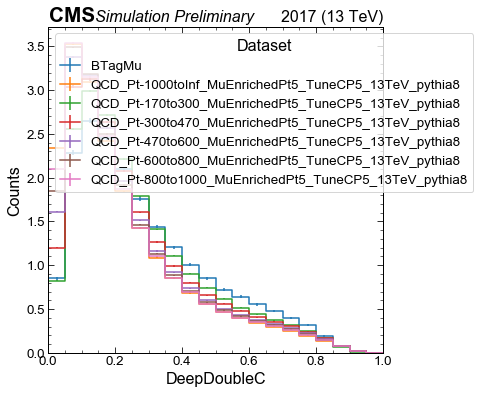

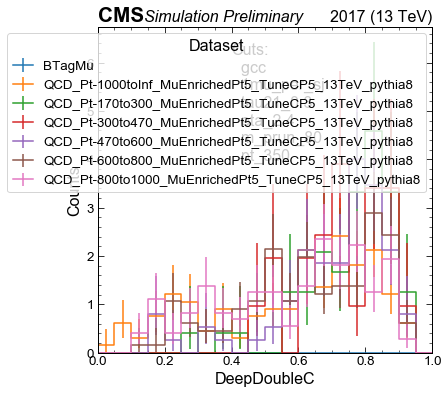

In [20]:
plt.style.use(["ROOTs"])
fig, ax, _ = plot.plot1d(output['ddc_raw'], overlay='dataset', density=True)
ax = cms_annot(ax)
fig, ax, _ = plot.plot1d(output['ddc'], overlay='dataset', density=True)
ax.annotate("Cuts:\n  "+"\n  ".join(apply_cuts), xy=(0.4, 0.95), xycoords='axes fraction', 
        ha='left', va='top', annotation_clip=False)
ax = cms_annot(ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(20, 600)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from fnal_column_analysis_tools.hist import plot

def compare(Hist, xaxis='ddc'):
    try:
        _test = Hist.project('dataset', "QCD", overflow='over')
        print(_test)
    except:
        print('Not a histogram')
        return
    ncat = Hist.axis('dataset').size
    fig, axs = plt.subplots(1, ncat, figsize=(16,7), sharex=True, sharey=True, tight_layout=True)
    for cat, ax in zip(Hist.axis('dataset').identifiers(), axs):
        fig, ax, _ = plot.plot2d(Hist.project('dataset', cat, overflow='over'), 
                                 log=True,
                                 xaxis=xaxis, ax=ax)
        ax.set_title(cat)
        #ax.zaxis.set_scale('log')
        #print(ax.get_children() )

    
for k in JetProcessor().axes.keys():
    if k == 'ddc': continue
    compare(output['cutddc_'+k])

In [ ]:
for k in JetProcessor().axes.keys():
    if k == 'doubleb': continue
    compare(output['cutdb_'+k], xaxis='doubleb')

In [ ]:
finbtup = uproot.open("JetTree_mc_FatJets_Subjets_BoostedCommissioning_12.root")
tb = finbtup["btaganaFatJets/ttree"]

In [ ]:
nj = tb['FatJetInfo.nJet'].array()
jets = awkward.JaggedArray.zip({
    'pt': tb['FatJetInfo.Jet_pt'].array(),
    'eta': tb['FatJetInfo.Jet_eta'].array(),
    'nsj': tb['FatJetInfo.Jet_nSubJets_SoftDropPuppi'].array(),
})

jnsj = tb['FatJetInfo.Jet_nSubJets_SoftDropPuppi'].array()
sj0 = tb['FatJetInfo.Jet_nFirstSJ_SoftDropPuppi'].array()
sjn = tb['FatJetInfo.Jet_nLastSJ_SoftDropPuppi'].array()
nsjidx = tb['FatJetInfo.nSubJet_SoftDropPuppi'].array()
sjidx = tb['FatJetInfo.SubJetIdx_SoftDropPuppi'].array()

nsubjets = tb['SoftDropPuppiSubJetInfo.nJet'].array()
subjets = awkward.JaggedArray.zip({
    'pt': tb['SoftDropPuppiSubJetInfo.Jet_pt'].array(),
    'eta': tb['SoftDropPuppiSubJetInfo.Jet_eta'].array(),
    'phi': tb['SoftDropPuppiSubJetInfo.Jet_phi'].array(),
    'flavour': tb['SoftDropPuppiSubJetInfo.Jet_flavour'].array(),
    'nsv': tb['SoftDropPuppiSubJetInfo.Jet_SV_multi'].array(),
})

In [ ]:
print(np.sum(nsubjets == nsjidx))

In [ ]:
print(f"Num events: {nj.shape}")
print("njet matches subjetidx counts:", np.array_equal(jnsj.counts, nj))
print("subjet indices less than nsubjets:", np.any(nsubjets < nsjidx))
print("nsjidx matches subjet index counts:", np.array_equal(nsjidx, sjidx.counts))
print("sum jet subjet indices matches length of indices array:", np.array_equal(jnsj.sum(), sjidx.counts))
print("subjet indices in range:", np.all(sjidx.max()<=nsubjets) and np.all(sjidx.min()>=0))
print("Jet nSubJets all consistent:", np.all((sj0 + jnsj == sjn).all()))

In [ ]:
nj = tb['FatJetInfo.nJet'].array()
jets = awkward.JaggedArray.zip({
    'pt': tb['FatJetInfo.Jet_pt'].array(),
    'eta': tb['FatJetInfo.Jet_eta'].array(),
    'nsj': tb['FatJetInfo.Jet_nSubJets_SoftDropPuppi'].array(),
})

jnsj = tb['FatJetInfo.Jet_nSubJets_SoftDropPuppi'].array()
sj0 = tb['FatJetInfo.Jet_nFirstSJ_SoftDropPuppi'].array()
sjn = tb['FatJetInfo.Jet_nLastSJ_SoftDropPuppi'].array()
nsjidx = tb['FatJetInfo.nSubJet_SoftDropPuppi'].array()
sjidx = tb['FatJetInfo.SubJetIdx_SoftDropPuppi'].array()

nsubjets = tb['SoftDropPuppiSubJetInfo.nJet'].array()
subjets = awkward.JaggedArray.zip({
    'pt': tb['SoftDropPuppiSubJetInfo.Jet_pt'].array(),
    'eta': tb['SoftDropPuppiSubJetInfo.Jet_eta'].array(),
    'phi': tb['SoftDropPuppiSubJetInfo.Jet_phi'].array(),
    'flavour': tb['SoftDropPuppiSubJetInfo.Jet_flavour'].array(),
    'nsv': tb['SoftDropPuppiSubJetInfo.Jet_SV_multi'].array(),
})
# only need jnsj, sjidx

# build double-jagged index array
subjetidx = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, sjidx.content))
# take advantage of broadcasting to turn into absolute index
subjetidx = (subjetidx + subjets.starts).flatten().flatten()
# use indexed array into actual subjet content
jet_subjet_content = awkward.IndexedArray(subjetidx, subjets.content)
# re-build double-jagged array now with content
jet_subjet = awkward.JaggedArray.fromoffsets(jnsj.offsets, awkward.JaggedArray.fromcounts(jnsj.content, jet_subjet_content))
jets['subjets'] = jet_subjet

#jets[:3].tolist()

In [ ]:
muons = awkward.JaggedArray.zip({
    'pt': tb['SoftDropPuppiSubJetInfo.PFMuon_pt'].array(),
    'eta': tb['SoftDropPuppiSubJetInfo.PFMuon_eta'].array(),
    'phi': tb['SoftDropPuppiSubJetInfo.PFMuon_phi'].array(),
    'subjetIdx': tb['SoftDropPuppiSubJetInfo.PFMuon_IdxJet'].array(),
})

print("Muon jetidx fits in subjets:", np.all(muons['subjetIdx'].max() < subjets.counts))
print("Muon jetidx fits in jets:", np.all(muons['subjetIdx'].max() < jets.counts))
print("Muon jetidx monotonic:", (muons['subjetIdx'][:,1:] - muons['subjetIdx'][:,:-1] >= 0).all().all())

# convert to absolute index
muon_absjetidx = (muons['subjetIdx'] + subjets.starts).flatten()
# use np.unique to get the number of muons associated with each subjet
subjet_nmuons = np.zeros(subjets.content.size, dtype=subjets.offsets.dtype)
subjets_wmuons, jet_muoncounts = np.unique(muon_absjetidx, return_counts=True)
subjet_nmuons[subjets_wmuons] = jet_muoncounts
# build the indexed table
subjet_muons = awkward.JaggedArray.fromoffsets(subjets.offsets, awkward.JaggedArray.fromcounts(subjet_nmuons, muons.content))
# this confirms that the inversion worked
print("Subjet->muon_subjet_idx corresponds to subjet indices:", (subjet_muons['subjetIdx'] == subjet_muons.index).all().all().all())

subjets['muons'] = subjet_muons

# Cuts
per_sj = ((jets['subjets']['nsv'] >=1).sum() >=2)

per_mu = (((jets['subjets']['muons']['pt'] >=2 ).sum() >= 1).sum() >=2)

